In [162]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

In [148]:
# Load the data
from main import OUTPUT_DIR

original_df = pd.read_json(Path(OUTPUT_DIR) / "output.json")
original_df.head()

,title,url,Specifications
0,A2-Cal Aptos Blue,https://evtol.news/a2-cal-aptos-blue,"[Aircraft type: eVTOL air ambulance aircraft, ..."
1,Ace VTOL GT Slipstream (concept design),https://evtol.news/ace-vtol-gt-slipstream-conc...,[Aircraft type: eVTOL or hybrid-electric VTOL ...
2,Ace VTOL Slipstream Elite (concept design),https://evtol.news/ace-vtol-slipstream-elite-c...,[Aircraft type: eVTOL or hybrid-electric VTOL ...
3,Ace VTOL Trinity (concept design),https://evtol.news/ace-vtol-trinity-concept-de...,[Aircraft type: eVTOL or hybrid-electric VTOL ...
4,ACS Aviation Z-300,https://evtol.news/acs-aviation-z-300/,"[Aircraft type: eVTOL, Piloting: Semi-autonomo..."


In [149]:
empty_specifications_rows = original_df["Specifications"].map(lambda x: len(x) == 0)
empty_specifications_rows.sum()

39

In [150]:
original_df = original_df.loc[~empty_specifications_rows, :]

In [151]:
specifications_dict = original_df["Specifications"].to_dict()
specifications_dict_edit = {}

sub_keys = []
for row_idx, specifications in specifications_dict.items():
    info_dict = {}
    for specification in specifications:
        specification: str

        slices = specification.split(":", 1)
        if len(slices) == 1:
            sub_key = "Extra info"
            content = slices[0]
        else:
            sub_key, content = slices

        sub_keys.append(sub_key)
        info_dict[sub_key] = content

    specifications_dict_edit[row_idx] = info_dict

sub_keys = set(sub_keys)
len(sub_keys)

735

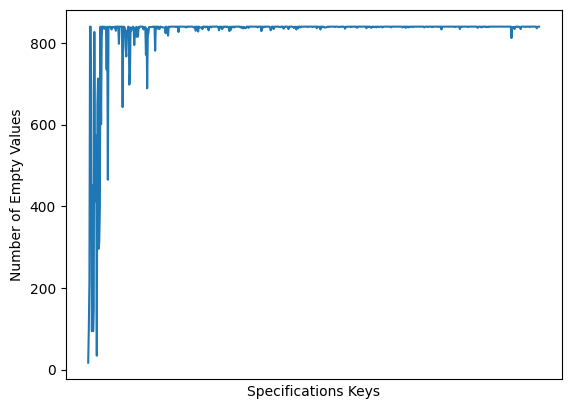

In [164]:
dict_for_new_df = specifications_dict_edit.copy()
new_df = pd.DataFrame.from_dict(dict_for_new_df, orient="index")
new_df.fillna("", inplace=True)

# Count the number of empty string values of each column
empty_counts_df = new_df.apply(lambda x: x == "").sum()
empty_counts_df.plot()
plt.xticks([])
plt.xlabel("Specifications Keys")
plt.ylabel("Number of Empty Values")
plt.show()

In [167]:
VALID_SUB_THRESHOLD = 200
valid_sub_keys = empty_counts_df[empty_counts_df < VALID_SUB_THRESHOLD].index.to_list()
valid_sub_keys

['Aircraft type',
 'Piloting',
 'Propellers',
 'Power source',
 'Fuselage',
 'Landing gear']

In [154]:
dict_for_new_df = specifications_dict_edit.copy()
extra_key = "extra info"
for row_idx, info_dict in dict_for_new_df.items():
    extra_info = ""
    new_info_dict = {}
    for k, v in list(info_dict.items()):
        if k in valid_sub_keys:
            new_info_dict[k] = v
        elif v:
            extra_info += f"{k}: {v}\n"

    new_info_dict[extra_key] = extra_info
    dict_for_new_df[row_idx] = new_info_dict

specifications_info_df = pd.DataFrame.from_dict(dict_for_new_df, orient="index")

In [155]:
final_df = pd.concat([original_df[original_df.columns[:2]], specifications_info_df], axis=1)
final_df.head()

,title,url,Aircraft type,Piloting,Propellers,Power source,Fuselage,Landing gear,extra info
0,A2-Cal Aptos Blue,https://evtol.news/a2-cal-aptos-blue,eVTOL air ambulance aircraft,1 pilot,8 propellers,8 Lithium-ion batteries,Carbon fiber composite,Tricycle wheeled retractable landing gear,Capacity: 3 people (including the pilot)\nEst...
1,Ace VTOL GT Slipstream (concept design),https://evtol.news/ace-vtol-gt-slipstream-conc...,eVTOL or hybrid-electric VTOL passenger and c...,Low earth orbit satellite-hosted blockchain a...,4 next gen plasma engines,Batteries with 8 second recharging or hybrid-...,Carbon fiber composite,Retractable quadricycle strut landing gear,Capacity: 2 passengers\nElectric motors: 12 ...
2,Ace VTOL Slipstream Elite (concept design),https://evtol.news/ace-vtol-slipstream-elite-c...,eVTOL or hybrid-electric VTOL passenger and c...,Low earth orbit satellite-hosted blockchain a...,4 next gen plasma engines,Batteries with 8 second recharging or hybrid-...,Carbon fiber composite,Retractable quadricycle strut landing gear,Capacity: 2 passengers\nElectric motors: 12 ...
3,Ace VTOL Trinity (concept design),https://evtol.news/ace-vtol-trinity-concept-de...,eVTOL or hybrid-electric VTOL passenger and c...,Low earth orbit satellite-hosted blockchain a...,3 next gen plasma engines,H2 range extending auxiliary power unit,Carbon fiber composite,Retractable quadricycle strut landing gear,Capacity: 4 to 7 passengers (and is wheelchai...
4,ACS Aviation Z-300,https://evtol.news/acs-aviation-z-300/,eVTOL,Semi-autonomous,NaN,NaN,NaN,Tail dragger. (Two wheels under the wings and...,Passengers: 2\nSeating configuration: Tandem...


In [156]:
final_df.fillna("", inplace=True)
final_df_empty_count = final_df.map(lambda x: x == "").sum()
final_df_empty_count.to_dict()

{'title': 0,
 'url': 0,
 'Aircraft type': 17,
 'Piloting': 100,
 'Propellers': 94,
 'Power source': 94,
 'Fuselage': 152,
 'Landing gear': 34,
 'extra info': 0}

In [160]:
# 根据final_df_empty_count数量，对final_df的列进行排序

# Convert the Series into a DataFrame
df_empty_count = final_df_empty_count.to_frame()

# Reset the index
df_empty_count.reset_index(level=0, inplace=True)

# Sort the DataFrame
df_empty_count_sorted = df_empty_count.sort_values(by=0)

# Get the sorted column names
sorted_columns = df_empty_count_sorted['index'].tolist()

pinned_columns = ['title', 'url', 'extra info']
sorted_columns = [c for c in sorted_columns if c not in pinned_columns]
sorted_columns = pinned_columns[:2] + sorted_columns + pinned_columns[2:]

# Reorder the columns of final_df
final_df = final_df[sorted_columns]
final_df.to_excel(Path(OUTPUT_DIR) / "evtol-news-aircraft.xlsx", index=False)